# Hands-on Machine Learning

## Session 7: Deep Learning

This lab is designed by Leon Weninger

### Goal of this session

In this session you will:
* implement a deep neural network
* learn about different layer types and activation functions
* experiment with visualization techniques

Mind that there are still a few things we hide behind the scenes:
* Data Loading / Handling is done using framework utilities (see additional pytorch doc)
* Data Augmentation will be covered in a later session

### Dataset

This session uses the PascalVOC dataset, which is accessible on this server.
The dataset comprises input images that can be classified with different strategies.
We consider an image classification problem, i.e. decide which objects from a finite set of classes appear in the input image.
Since multiple objects may appear in each image, this is a multi-label classification task.

Let's dive right into the task:
Make sure to run the imports and continue loading the dataset to RAM.

In [2]:
import os
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import DataLoader

%matplotlib inline

First, we define if the network should run on GPU or CPU. On the official tutorial machines, a GPU is available. Remember later on to specify the network to run on "device".

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Loading the dataset

We prepared a loader for you that can automatically grab a training- and testset.

In [4]:
dset_path = os.path.join(os.path.abspath(os.environ["HOME"]), 'datasets')
try:
    voc_train = VOCSegmentation(root=dset_path, download=False, image_set="train")
    voc_val = VOCSegmentation(root=dset_path, download=False, image_set="val")
except RuntimeError:
    if not os.path.isdir(dset_path):
            os.makedirs(dset_path)
    VOCSegmentation(root=dset_path, download=True)
    voc_train = VOCSegmentation(root=dset_path, download=False, image_set="train")
    voc_val = VOCSegmentation(root=dset_path, download=False, image_set="val")

A simple lookup table from numerical values to names of the objects

In [5]:
class_to_label = {0: 'background', 1:'aeroplane', 2:'bicycle', 3:'bird', 4:'boat', 5:'bottle', 6:'bus', 7:'car', 8:'cat', 9:'chair', 10:'cow', 11:'diningtable',
12:'dog', 13:'horse', 14:'motorbike', 15:'person', 16:'potted plant', 17:'sheep', 18:'sofa', 19:'train', 20:'tv/monitor'}

Run the cell below a few times to get an overview of the data available.
The labels assigned to the classes are shown above the images

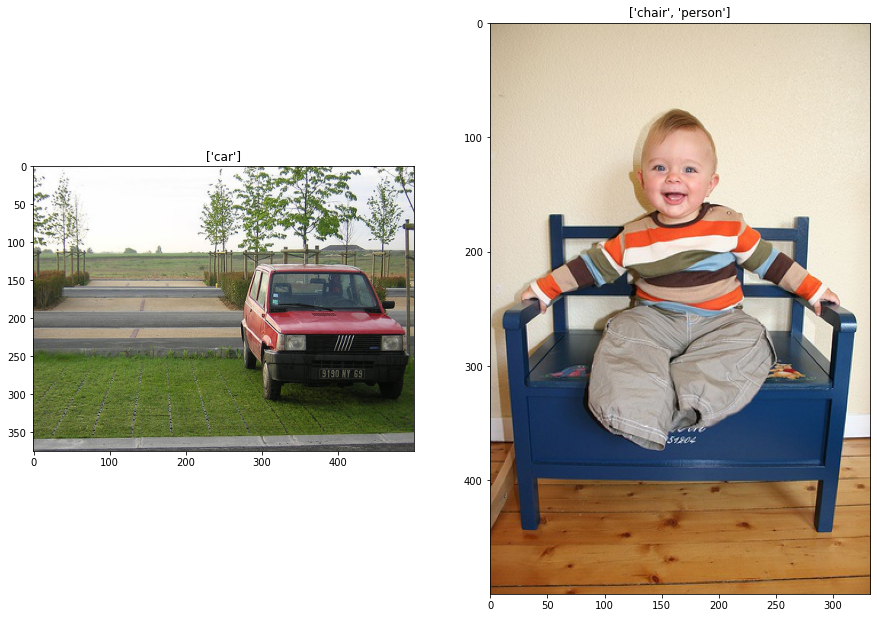

In [6]:
plt.subplots(2, 1, figsize=(15,15))
for i in range(2):
    img, mask = voc_train[np.random.randint(0,voc_train.__len__() + 1)]
    plt.subplot(1,2,i+1)
    plt.imshow(img)
    numerical_labels = np.unique(mask)
    plt.title([class_to_label[i] for i in numerical_labels[1:-1]])
plt.show()

## Building a network

### Defining functional units

As introduced in the preparation, we are going to implement a VGGNet model as a classifier.
From the previous session you know the setup of classical Multilayer Perceptrons.

**Q1a:** Which other layer types appear in the VGG architecture?

Solution: Convolutional Layer, Batchnormalization Layer, Dropout Layer, MaxPooling Layer, ReLU Layer

The VGG architecture has a rather simple structure

**Q1b:** How can a VGG net be structured in small functional units (3-4 layers)?

Solution: We can combine convolutional and pooling layers into a single block.

#### ... write your answers/ideas in this box

The blocks of the VGGNet should look like this:
![Blockstructure](vgg16block-structure.png "Blockstructure")
Note that this structure is a little bit different from the original architecture. and reflects some recent advances in Deep Learning

**TASK** Implement the class below.

*Hint:* implement a functional block by defining a new python class which inherits from nn.Module (see pytorch doc).
You have to write an *init* and *forward* method. 

In [7]:
class VGGBlock(nn.Module):
    def __init__(self, ifeat, ofeat, N=2):
        super(VGGBlock, self).__init__()
        assert(N in (2, 3))
        
        self.N=N
        # setup all layers inside a VGG block here
        self.conv1=nn.Conv2d(ifeat,ofeat,3,padding=1,stride=1)
        self.bn1=nn.BatchNorm2d(ofeat)
        self.conv2=nn.Conv2d(ofeat,ofeat,3,padding=1,stride=1)
        self.bn2=nn.BatchNorm2d(ofeat)
        self.conv3=nn.Conv2d(ofeat,ofeat,3,padding=1,stride=1)
        self.bn3=nn.BatchNorm2d(ofeat)
        self.pool1=nn.MaxPool2d(kernel_size=2,stride=2)        
        
    def forward(self, x):
        
        # define the forward method
        # keep in mind that some blocks have 2 sub-blocks, others 3. This should be decided based on the value of N
        x=self.conv1(x)
        x=self.bn1(x)
        x=F.relu(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=F.relu(x)
        if self.N==3:
            x=self.conv3(x)
            x=self.bn3(x)
            x=F.relu(x)
        x=self.pool1(x)
        return x


### Main Architecture

The standard VGG Net is used to predict a single class. Recall that in PascalVOC multiple objects may be present in an image.

**Q2:** What changes between a single and multi-label scenario?

Solution: We cannot use softmax as the activation function for the multi-label scenario.

#### ... write your answers/ideas in this box

Since the number of classes in PascalVOC is much smaller than in the ILSCVR Challenge (where VGG16 was benchmarked) the number of parameters for the Linear Layers can drastically be reduced in this session. Use _1024_ instead of _4096_ parameters.

**TASK** Using the block diagram in the preparation and your pytorch module above, implement a VGG-16 network as nn.Module.

In [8]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        
        # set up the blocks for the feature extractor part
        self.block1 = VGGBlock(3, 64)
        self.block2 = VGGBlock(64, 128)
        self.block3 = VGGBlock(128, 256, N=3)
        self.block4 = VGGBlock(256, 512, N=3)
        self.block5 = VGGBlock(512, 512, N=3)
        
        k = 0 # size of the feature plane after the extractor
        
        # set up the dense layers here, this is the classifier part of the network
        # don't forget the Dropout for a better learning behaviour
        self.fc1=nn.Linear(512*10*10,1024)
        self.fc2=nn.Linear(1024,1024)
        self.fc3=nn.Linear(1024,20)
        self.drop1=nn.Dropout(0.5)
        self.drop2=nn.Dropout(0.5)
        

    def forward(self, x):
        # implement the forward function
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        x=x.view(x.shape[0],-1)
        x=self.fc1(x)
        x=F.relu(x)
        x=self.drop1(x)
        x=self.fc2(x)
        x=F.relu(x)
        x=self.drop2(x)
        x=self.fc3(x)
        #x=self.sm1(x)
        # print(x.size())  # useful for finding the 'k' above
        
        #print(x.size())
        
        # x = torch.flatten(x, 1)  # this call transforms the 2D feature field into a vector

        # implement the classifier function
        
        return x

### Data Preparation

This part covers necessary preparations to use the images from PascalVOC in the training process.
Read through the implementations below and using the pytorch doc explore what is done here.

In [9]:
class ToLabel(object):
    def __call__(self, pic):
        img = np.array(pic, np.uint8, copy=False)
        labels = np.unique(img)[1:-1]
        one_hot_targets = np.zeros(20)
        one_hot_targets[labels-1] = 1
        # we need to subtract one from labels, so that labels reaches from 0 to 19 (not from 1 to 20 as originally)
        return torch.from_numpy(one_hot_targets).float()

mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

inp_transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*mean_std)
])

tgt_transform = transforms.Compose([
    ToLabel(),
]
)

train_set = VOCSegmentation(root=dset_path, image_set='train', transform=inp_transform, target_transform=tgt_transform)
valid_set = VOCSegmentation(root=dset_path, image_set='val', transform=inp_transform, target_transform=tgt_transform)

train_loader = DataLoader(train_set, batch_size=8, num_workers=0, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=32, num_workers=0, shuffle=True)

## Training Loop

**Q3:** How is the training process structured? Which steps form an epoch?

Solution: We use the forward process to get the output of the network and the loss between the target and the output, use the gradient descent during the backward process to update the parameters for the optimizer. The forward and backward process over the whole training dataset form an epoch.

#### ... write your answers/ideas in this box

**TASK** Implement a training loop for the VGG16 model.
In PyTorch you need to set up model, loss function and optimizer. This is done as initialization before entering the loop.
During trainig we iterate multiple times through the dataset until the loss is not reduced any further.
Iteration in mini-batches is necessary since using the entire dataset at once would largely exceed the GPUs memory capacity.

For an improved estimation of the actual performance we iterate over the validation data as well (*Recap* session on unbiased evaluation).

In [11]:
from tqdm import tqdm
network = VGG16()

# send the network to the GPU
network.to(device)

# initialize your loss criterion
criterion=nn.BCEWithLogitsLoss()

# initialize an optimizer object
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)


for epoch in range(3):
    
    ep_train_losses = []
    for batch_nr, data in enumerate(tqdm(train_loader)):
        # get the required data and labels and wrap them in variables for the GPU processing
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # (optional) write some visualization to check if it works
#         if batch_nr==0:
#             print(inputs.size())
#             imshow(torchvision.utils.make_grid(inputs))
        
        # compute a loss from the network output
        outputs = network(inputs)
        loss = criterion(outputs, labels)
            
        # zero old gradient values
        optimizer.zero_grad()
        
        # compute new gradients
        loss.backward()
        
        # update weights
        optimizer.step()
        
        # write some updating output for the current loss
        ep_train_losses.append(loss.item())
        
        print(f"epoch: {epoch} loss: {loss.item()}")
        
    
    with torch.no_grad():
        ep_valid_losses = []
        for batch_nr, data in enumerate(val_loader):
            # repeat the steps above for the validation set
            # which steps have to be skipped?
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            ep_valid_losses.append(loss.item())


# save your trained model if you want to
# ...



  1%|          | 1/183 [00:00<02:52,  1.05it/s]

epoch: 0 loss: 0.6934372186660767



  1%|          | 2/183 [00:01<02:48,  1.07it/s]

epoch: 0 loss: 0.6936484575271606



  2%|▏         | 3/183 [00:02<02:44,  1.10it/s]

epoch: 0 loss: 0.6798108816146851



  2%|▏         | 4/183 [00:03<02:40,  1.12it/s]

epoch: 0 loss: 0.6714764833450317



  3%|▎         | 5/183 [00:04<02:38,  1.12it/s]

epoch: 0 loss: 0.6495935320854187



  3%|▎         | 6/183 [00:05<02:35,  1.14it/s]

epoch: 0 loss: 0.6357136964797974



  4%|▍         | 7/183 [00:06<02:34,  1.14it/s]

epoch: 0 loss: 0.6141877174377441



  4%|▍         | 8/183 [00:07<02:32,  1.15it/s]

epoch: 0 loss: 0.5883664488792419



  5%|▍         | 9/183 [00:07<02:31,  1.15it/s]

epoch: 0 loss: 0.5948953628540039



  5%|▌         | 10/183 [00:08<02:29,  1.16it/s]

epoch: 0 loss: 0.5764654278755188



  6%|▌         | 11/183 [00:09<02:28,  1.16it/s]

epoch: 0 loss: 0.566170871257782



  7%|▋         | 12/183 [00:10<02:26,  1.17it/s]

epoch: 0 loss: 0.5129052996635437



  7%|▋         | 13/183 [00:11<02:26,  1.16it/s]

epoch: 0 loss: 0.5011362433433533



  8%|▊         | 14/183 [00:12<02:25,  1.16it/s]

epoch: 0 loss: 0.49020105600357056



  8%|▊         | 15/183 [00:13<02:24,  1.16it/s]

epoch: 0 loss: 0.47930923104286194



  9%|▊         | 16/183 [00:13<02:23,  1.16it/s]

epoch: 0 loss: 0.4572749137878418



  9%|▉         | 17/183 [00:14<02:22,  1.16it/s]

epoch: 0 loss: 0.41430598497390747



 10%|▉         | 18/183 [00:15<02:21,  1.16it/s]

epoch: 0 loss: 0.39652106165885925



 10%|█         | 19/183 [00:16<02:20,  1.17it/s]

epoch: 0 loss: 0.3953632414340973



 11%|█         | 20/183 [00:17<02:20,  1.16it/s]

epoch: 0 loss: 0.3533613979816437



 11%|█▏        | 21/183 [00:18<02:19,  1.16it/s]

epoch: 0 loss: 0.3039119243621826



 12%|█▏        | 22/183 [00:19<02:18,  1.17it/s]

epoch: 0 loss: 0.32671523094177246



 13%|█▎        | 23/183 [00:19<02:18,  1.16it/s]

epoch: 0 loss: 0.3487865626811981



 13%|█▎        | 24/183 [00:20<02:16,  1.16it/s]

epoch: 0 loss: 0.35524195432662964



 14%|█▎        | 25/183 [00:21<02:16,  1.16it/s]

epoch: 0 loss: 0.31249818205833435



 14%|█▍        | 26/183 [00:22<02:15,  1.16it/s]

epoch: 0 loss: 0.2787829339504242



 15%|█▍        | 27/183 [00:23<02:14,  1.16it/s]

epoch: 0 loss: 0.28220391273498535



 15%|█▌        | 28/183 [00:24<02:14,  1.15it/s]

epoch: 0 loss: 0.28116467595100403



 16%|█▌        | 29/183 [00:25<02:13,  1.15it/s]

epoch: 0 loss: 0.36406242847442627



 16%|█▋        | 30/183 [00:25<02:12,  1.15it/s]

epoch: 0 loss: 0.2636176347732544



 17%|█▋        | 31/183 [00:26<02:12,  1.15it/s]

epoch: 0 loss: 0.3224778175354004



 17%|█▋        | 32/183 [00:27<02:11,  1.15it/s]

epoch: 0 loss: 0.26269420981407166



 18%|█▊        | 33/183 [00:28<02:10,  1.15it/s]

epoch: 0 loss: 0.35001513361930847



 19%|█▊        | 34/183 [00:29<02:09,  1.15it/s]

epoch: 0 loss: 0.25618937611579895



 19%|█▉        | 35/183 [00:30<02:08,  1.15it/s]

epoch: 0 loss: 0.33369800448417664



 20%|█▉        | 36/183 [00:31<02:08,  1.15it/s]

epoch: 0 loss: 0.31817179918289185



 20%|██        | 37/183 [00:32<02:06,  1.15it/s]

epoch: 0 loss: 0.27283012866973877



 21%|██        | 38/183 [00:32<02:05,  1.16it/s]

epoch: 0 loss: 0.3185834288597107



 21%|██▏       | 39/183 [00:33<02:04,  1.16it/s]

epoch: 0 loss: 0.2384697049856186



 22%|██▏       | 40/183 [00:34<02:04,  1.15it/s]

epoch: 0 loss: 0.28925615549087524



 22%|██▏       | 41/183 [00:35<02:03,  1.15it/s]

epoch: 0 loss: 0.3258186876773834



 23%|██▎       | 42/183 [00:36<02:02,  1.15it/s]

epoch: 0 loss: 0.34440892934799194



 23%|██▎       | 43/183 [00:37<02:01,  1.16it/s]

epoch: 0 loss: 0.2444174736738205



 24%|██▍       | 44/183 [00:38<02:01,  1.15it/s]

epoch: 0 loss: 0.25369641184806824



 25%|██▍       | 45/183 [00:39<02:00,  1.14it/s]

epoch: 0 loss: 0.26286405324935913



 25%|██▌       | 46/183 [00:39<01:59,  1.15it/s]

epoch: 0 loss: 0.3183903992176056



 26%|██▌       | 47/183 [00:40<01:58,  1.14it/s]

epoch: 0 loss: 0.36968204379081726



 26%|██▌       | 48/183 [00:41<01:57,  1.15it/s]

epoch: 0 loss: 0.21604005992412567



 27%|██▋       | 49/183 [00:42<01:56,  1.15it/s]

epoch: 0 loss: 0.2417256385087967



 27%|██▋       | 50/183 [00:43<01:55,  1.15it/s]

epoch: 0 loss: 0.26913654804229736



 28%|██▊       | 51/183 [00:44<01:55,  1.15it/s]

epoch: 0 loss: 0.331356406211853



 28%|██▊       | 52/183 [00:45<01:54,  1.15it/s]

epoch: 0 loss: 0.25223642587661743



 29%|██▉       | 53/183 [00:45<01:53,  1.15it/s]

epoch: 0 loss: 0.2559491693973541



 30%|██▉       | 54/183 [00:46<01:52,  1.15it/s]

epoch: 0 loss: 0.35913971066474915



 30%|███       | 55/183 [00:47<01:50,  1.15it/s]

epoch: 0 loss: 0.27816125750541687



 31%|███       | 56/183 [00:48<01:50,  1.15it/s]

epoch: 0 loss: 0.29001083970069885



 31%|███       | 57/183 [00:49<01:49,  1.15it/s]

epoch: 0 loss: 0.19321918487548828



 32%|███▏      | 58/183 [00:50<01:48,  1.15it/s]

epoch: 0 loss: 0.24285300076007843



 32%|███▏      | 59/183 [00:51<01:47,  1.15it/s]

epoch: 0 loss: 0.3221479654312134



 33%|███▎      | 60/183 [00:52<01:47,  1.15it/s]

epoch: 0 loss: 0.24795742332935333



 33%|███▎      | 61/183 [00:52<01:46,  1.15it/s]

epoch: 0 loss: 0.29662615060806274



 34%|███▍      | 62/183 [00:53<01:45,  1.15it/s]

epoch: 0 loss: 0.31861287355422974



 34%|███▍      | 63/183 [00:54<01:44,  1.15it/s]

epoch: 0 loss: 0.31894293427467346



 35%|███▍      | 64/183 [00:55<01:43,  1.15it/s]

epoch: 0 loss: 0.23184137046337128



 36%|███▌      | 65/183 [00:56<01:42,  1.16it/s]

epoch: 0 loss: 0.2111952304840088



 36%|███▌      | 66/183 [00:57<01:40,  1.16it/s]

epoch: 0 loss: 0.35094380378723145



 37%|███▋      | 67/183 [00:58<01:40,  1.16it/s]

epoch: 0 loss: 0.25333601236343384



 37%|███▋      | 68/183 [00:59<01:40,  1.15it/s]

epoch: 0 loss: 0.25011497735977173



 38%|███▊      | 69/183 [00:59<01:39,  1.14it/s]

epoch: 0 loss: 0.33094674348831177



 38%|███▊      | 70/183 [01:00<01:38,  1.14it/s]

epoch: 0 loss: 0.2638789117336273



 39%|███▉      | 71/183 [01:01<01:38,  1.14it/s]

epoch: 0 loss: 0.2763350307941437



 39%|███▉      | 72/183 [01:02<01:37,  1.14it/s]

epoch: 0 loss: 0.2552386224269867



 40%|███▉      | 73/183 [01:03<01:36,  1.14it/s]

epoch: 0 loss: 0.2546081244945526



 40%|████      | 74/183 [01:04<01:35,  1.14it/s]

epoch: 0 loss: 0.3146798312664032



 41%|████      | 75/183 [01:05<01:34,  1.14it/s]

epoch: 0 loss: 0.26645058393478394



 42%|████▏     | 76/183 [01:06<01:33,  1.14it/s]

epoch: 0 loss: 0.2821499705314636



 42%|████▏     | 77/183 [01:06<01:33,  1.14it/s]

epoch: 0 loss: 0.26183950901031494



 43%|████▎     | 78/183 [01:07<01:32,  1.14it/s]

epoch: 0 loss: 0.28614702820777893



 43%|████▎     | 79/183 [01:08<01:31,  1.14it/s]

epoch: 0 loss: 0.23230507969856262



 44%|████▎     | 80/183 [01:09<01:30,  1.14it/s]

epoch: 0 loss: 0.23813770711421967



 44%|████▍     | 81/183 [01:10<01:29,  1.14it/s]

epoch: 0 loss: 0.2394738495349884



 45%|████▍     | 82/183 [01:11<01:28,  1.14it/s]

epoch: 0 loss: 0.2148856669664383



 45%|████▌     | 83/183 [01:12<01:27,  1.14it/s]

epoch: 0 loss: 0.28590548038482666



 46%|████▌     | 84/183 [01:13<01:26,  1.14it/s]

epoch: 0 loss: 0.2605416774749756



 46%|████▋     | 85/183 [01:13<01:25,  1.14it/s]

epoch: 0 loss: 0.2910352647304535



 47%|████▋     | 86/183 [01:14<01:24,  1.14it/s]

epoch: 0 loss: 0.2692134380340576



 48%|████▊     | 87/183 [01:15<01:24,  1.14it/s]

epoch: 0 loss: 0.30054712295532227



 48%|████▊     | 88/183 [01:16<01:23,  1.14it/s]

epoch: 0 loss: 0.3165230453014374



 49%|████▊     | 89/183 [01:17<01:22,  1.14it/s]

epoch: 0 loss: 0.2786853313446045



 49%|████▉     | 90/183 [01:18<01:21,  1.14it/s]

epoch: 0 loss: 0.270843505859375



 50%|████▉     | 91/183 [01:19<01:20,  1.14it/s]

epoch: 0 loss: 0.337236613035202



 50%|█████     | 92/183 [01:20<01:20,  1.14it/s]

epoch: 0 loss: 0.2802228629589081



 51%|█████     | 93/183 [01:20<01:19,  1.14it/s]

epoch: 0 loss: 0.2511533200740814



 51%|█████▏    | 94/183 [01:21<01:18,  1.14it/s]

epoch: 0 loss: 0.23395411670207977



 52%|█████▏    | 95/183 [01:22<01:17,  1.14it/s]

epoch: 0 loss: 0.2510707974433899



 52%|█████▏    | 96/183 [01:23<01:16,  1.13it/s]

epoch: 0 loss: 0.24992156028747559



 53%|█████▎    | 97/183 [01:24<01:16,  1.13it/s]

epoch: 0 loss: 0.2777419984340668



 54%|█████▎    | 98/183 [01:25<01:15,  1.13it/s]

epoch: 0 loss: 0.27304917573928833



 54%|█████▍    | 99/183 [01:26<01:14,  1.13it/s]

epoch: 0 loss: 0.23802757263183594



 55%|█████▍    | 100/183 [01:27<01:13,  1.13it/s]

epoch: 0 loss: 0.24629662930965424



 55%|█████▌    | 101/183 [01:28<01:12,  1.13it/s]

epoch: 0 loss: 0.28902092576026917



 56%|█████▌    | 102/183 [01:28<01:11,  1.14it/s]

epoch: 0 loss: 0.19612137973308563



 56%|█████▋    | 103/183 [01:29<01:10,  1.14it/s]

epoch: 0 loss: 0.2908751666545868



 57%|█████▋    | 104/183 [01:30<01:09,  1.14it/s]

epoch: 0 loss: 0.33795973658561707



 57%|█████▋    | 105/183 [01:31<01:08,  1.14it/s]

epoch: 0 loss: 0.3213110864162445



 58%|█████▊    | 106/183 [01:32<01:07,  1.14it/s]

epoch: 0 loss: 0.2525195777416229



 58%|█████▊    | 107/183 [01:33<01:06,  1.15it/s]

epoch: 0 loss: 0.24144302308559418



 59%|█████▉    | 108/183 [01:34<01:05,  1.14it/s]

epoch: 0 loss: 0.26824313402175903



 60%|█████▉    | 109/183 [01:35<01:04,  1.14it/s]

epoch: 0 loss: 0.28649649024009705



 60%|██████    | 110/183 [01:35<01:04,  1.14it/s]

epoch: 0 loss: 0.27410563826560974



 61%|██████    | 111/183 [01:36<01:03,  1.13it/s]

epoch: 0 loss: 0.3361712396144867



 61%|██████    | 112/183 [01:37<01:02,  1.14it/s]

epoch: 0 loss: 0.24964824318885803



 62%|██████▏   | 113/183 [01:38<01:01,  1.14it/s]

epoch: 0 loss: 0.2637128531932831



 62%|██████▏   | 114/183 [01:39<01:00,  1.14it/s]

epoch: 0 loss: 0.2991362512111664



 63%|██████▎   | 115/183 [01:40<00:59,  1.14it/s]

epoch: 0 loss: 0.22814960777759552



 63%|██████▎   | 116/183 [01:41<00:58,  1.14it/s]

epoch: 0 loss: 0.2440420687198639



 64%|██████▍   | 117/183 [01:42<00:57,  1.14it/s]

epoch: 0 loss: 0.21982799470424652



 64%|██████▍   | 118/183 [01:42<00:57,  1.14it/s]

epoch: 0 loss: 0.2807259261608124



 65%|██████▌   | 119/183 [01:43<00:56,  1.14it/s]

epoch: 0 loss: 0.25332826375961304



 66%|██████▌   | 120/183 [01:44<00:55,  1.14it/s]

epoch: 0 loss: 0.2791406810283661



 66%|██████▌   | 121/183 [01:45<00:54,  1.14it/s]

epoch: 0 loss: 0.2387114018201828



 67%|██████▋   | 122/183 [01:46<00:53,  1.14it/s]

epoch: 0 loss: 0.3016601502895355



 67%|██████▋   | 123/183 [01:47<00:52,  1.14it/s]

epoch: 0 loss: 0.2281322479248047



 68%|██████▊   | 124/183 [01:48<00:51,  1.14it/s]

epoch: 0 loss: 0.2688924968242645



 68%|██████▊   | 125/183 [01:49<00:50,  1.14it/s]

epoch: 0 loss: 0.23669806122779846



 69%|██████▉   | 126/183 [01:49<00:50,  1.14it/s]

epoch: 0 loss: 0.2887217700481415



 69%|██████▉   | 127/183 [01:50<00:49,  1.14it/s]

epoch: 0 loss: 0.25956106185913086



 70%|██████▉   | 128/183 [01:51<00:48,  1.14it/s]

epoch: 0 loss: 0.2828271985054016



 70%|███████   | 129/183 [01:52<00:47,  1.14it/s]

epoch: 0 loss: 0.24870240688323975



 71%|███████   | 130/183 [01:53<00:46,  1.14it/s]

epoch: 0 loss: 0.23689089715480804



 72%|███████▏  | 131/183 [01:54<00:45,  1.14it/s]

epoch: 0 loss: 0.2174983024597168



 72%|███████▏  | 132/183 [01:55<00:44,  1.14it/s]

epoch: 0 loss: 0.2053106129169464



 73%|███████▎  | 133/183 [01:56<00:43,  1.14it/s]

epoch: 0 loss: 0.2574026584625244



 73%|███████▎  | 134/183 [01:56<00:43,  1.14it/s]

epoch: 0 loss: 0.2735578417778015



 74%|███████▍  | 135/183 [01:57<00:42,  1.14it/s]

epoch: 0 loss: 0.21603095531463623



 74%|███████▍  | 136/183 [01:58<00:41,  1.14it/s]

epoch: 0 loss: 0.24771510064601898



 75%|███████▍  | 137/183 [01:59<00:40,  1.13it/s]

epoch: 0 loss: 0.22591523826122284



 75%|███████▌  | 138/183 [02:00<00:39,  1.14it/s]

epoch: 0 loss: 0.2929137647151947



 76%|███████▌  | 139/183 [02:01<00:38,  1.13it/s]

epoch: 0 loss: 0.26394030451774597



 77%|███████▋  | 140/183 [02:02<00:37,  1.13it/s]

epoch: 0 loss: 0.3282357156276703



 77%|███████▋  | 141/183 [02:03<00:36,  1.14it/s]

epoch: 0 loss: 0.23569369316101074



 78%|███████▊  | 142/183 [02:04<00:35,  1.14it/s]

epoch: 0 loss: 0.3340086042881012



 78%|███████▊  | 143/183 [02:04<00:35,  1.14it/s]

epoch: 0 loss: 0.33689337968826294



 79%|███████▊  | 144/183 [02:05<00:34,  1.14it/s]

epoch: 0 loss: 0.28577297925949097



 79%|███████▉  | 145/183 [02:06<00:33,  1.15it/s]

epoch: 0 loss: 0.262524276971817



 80%|███████▉  | 146/183 [02:07<00:32,  1.15it/s]

epoch: 0 loss: 0.23249657452106476



 80%|████████  | 147/183 [02:08<00:31,  1.15it/s]

epoch: 0 loss: 0.2518753707408905



 81%|████████  | 148/183 [02:09<00:30,  1.15it/s]

epoch: 0 loss: 0.2657453119754791



 81%|████████▏ | 149/183 [02:10<00:29,  1.15it/s]

epoch: 0 loss: 0.3010905683040619



 82%|████████▏ | 150/183 [02:10<00:28,  1.14it/s]

epoch: 0 loss: 0.2508637607097626



 83%|████████▎ | 151/183 [02:11<00:27,  1.15it/s]

epoch: 0 loss: 0.26674219965934753



 83%|████████▎ | 152/183 [02:12<00:27,  1.15it/s]

epoch: 0 loss: 0.2878377139568329



 84%|████████▎ | 153/183 [02:13<00:26,  1.15it/s]

epoch: 0 loss: 0.2869495451450348



 84%|████████▍ | 154/183 [02:14<00:25,  1.14it/s]

epoch: 0 loss: 0.3214902877807617



 85%|████████▍ | 155/183 [02:15<00:24,  1.14it/s]

epoch: 0 loss: 0.25570642948150635



 85%|████████▌ | 156/183 [02:16<00:23,  1.14it/s]

epoch: 0 loss: 0.2267463654279709



 86%|████████▌ | 157/183 [02:17<00:22,  1.14it/s]

epoch: 0 loss: 0.23400750756263733



 86%|████████▋ | 158/183 [02:18<00:21,  1.14it/s]

epoch: 0 loss: 0.3022215664386749



 87%|████████▋ | 159/183 [02:18<00:21,  1.14it/s]

epoch: 0 loss: 0.29419782757759094



 87%|████████▋ | 160/183 [02:19<00:20,  1.14it/s]

epoch: 0 loss: 0.2497616857290268



 88%|████████▊ | 161/183 [02:20<00:19,  1.14it/s]

epoch: 0 loss: 0.32550522685050964



 89%|████████▊ | 162/183 [02:21<00:18,  1.14it/s]

epoch: 0 loss: 0.2659587860107422



 89%|████████▉ | 163/183 [02:22<00:17,  1.14it/s]

epoch: 0 loss: 0.2593899369239807



 90%|████████▉ | 164/183 [02:23<00:16,  1.14it/s]

epoch: 0 loss: 0.3037043511867523



 90%|█████████ | 165/183 [02:24<00:15,  1.14it/s]

epoch: 0 loss: 0.2566302716732025



 91%|█████████ | 166/183 [02:25<00:14,  1.14it/s]

epoch: 0 loss: 0.31869521737098694



 91%|█████████▏| 167/183 [02:25<00:14,  1.14it/s]

epoch: 0 loss: 0.2671087682247162



 92%|█████████▏| 168/183 [02:26<00:13,  1.14it/s]

epoch: 0 loss: 0.24926185607910156



 92%|█████████▏| 169/183 [02:27<00:12,  1.13it/s]

epoch: 0 loss: 0.27672022581100464



 93%|█████████▎| 170/183 [02:28<00:11,  1.13it/s]

epoch: 0 loss: 0.2740688621997833



 93%|█████████▎| 171/183 [02:29<00:10,  1.14it/s]

epoch: 0 loss: 0.2318083792924881



 94%|█████████▍| 172/183 [02:30<00:09,  1.14it/s]

epoch: 0 loss: 0.23658059537410736



 95%|█████████▍| 173/183 [02:31<00:08,  1.14it/s]

epoch: 0 loss: 0.22033558785915375



 95%|█████████▌| 174/183 [02:32<00:07,  1.13it/s]

epoch: 0 loss: 0.23684822022914886



 96%|█████████▌| 175/183 [02:32<00:07,  1.14it/s]

epoch: 0 loss: 0.27832791209220886



 96%|█████████▌| 176/183 [02:33<00:06,  1.14it/s]

epoch: 0 loss: 0.3064640462398529



 97%|█████████▋| 177/183 [02:34<00:05,  1.13it/s]

epoch: 0 loss: 0.32194027304649353



 97%|█████████▋| 178/183 [02:35<00:04,  1.13it/s]

epoch: 0 loss: 0.30705830454826355



 98%|█████████▊| 179/183 [02:36<00:03,  1.14it/s]

epoch: 0 loss: 0.25454238057136536



 98%|█████████▊| 180/183 [02:37<00:02,  1.14it/s]

epoch: 0 loss: 0.23633816838264465



 99%|█████████▉| 181/183 [02:38<00:01,  1.14it/s]

epoch: 0 loss: 0.22951701283454895



 99%|█████████▉| 182/183 [02:39<00:00,  1.14it/s]

epoch: 0 loss: 0.2804534435272217



100%|██████████| 183/183 [02:39<00:00,  1.14it/s]

epoch: 0 loss: 0.2652432918548584




  1%|          | 1/183 [00:00<02:38,  1.15it/s]

epoch: 1 loss: 0.25876733660697937



  1%|          | 2/183 [00:01<02:37,  1.15it/s]

epoch: 1 loss: 0.2807595729827881



  2%|▏         | 3/183 [00:02<02:36,  1.15it/s]

epoch: 1 loss: 0.24708862602710724



  2%|▏         | 4/183 [00:03<02:36,  1.15it/s]

epoch: 1 loss: 0.23921988904476166



  3%|▎         | 5/183 [00:04<02:35,  1.14it/s]

epoch: 1 loss: 0.24399755895137787



  3%|▎         | 6/183 [00:05<02:35,  1.14it/s]

epoch: 1 loss: 0.2454799860715866



  4%|▍         | 7/183 [00:06<02:34,  1.14it/s]

epoch: 1 loss: 0.26952415704727173



  4%|▍         | 8/183 [00:07<02:34,  1.13it/s]

epoch: 1 loss: 0.1984836310148239



  5%|▍         | 9/183 [00:07<02:33,  1.13it/s]

epoch: 1 loss: 0.2741006314754486



  5%|▌         | 10/183 [00:08<02:32,  1.13it/s]

epoch: 1 loss: 0.30982375144958496



  6%|▌         | 11/183 [00:09<02:31,  1.13it/s]

epoch: 1 loss: 0.31440672278404236



  7%|▋         | 12/183 [00:10<02:30,  1.13it/s]

epoch: 1 loss: 0.2784782350063324



  7%|▋         | 13/183 [00:11<02:29,  1.14it/s]

epoch: 1 loss: 0.2798035740852356



  8%|▊         | 14/183 [00:12<02:28,  1.14it/s]

epoch: 1 loss: 0.34645920991897583



  8%|▊         | 15/183 [00:13<02:26,  1.14it/s]

epoch: 1 loss: 0.25488191843032837



  9%|▊         | 16/183 [00:14<02:25,  1.14it/s]

epoch: 1 loss: 0.30431056022644043



  9%|▉         | 17/183 [00:14<02:25,  1.14it/s]

epoch: 1 loss: 0.3137264549732208



 10%|▉         | 18/183 [00:15<02:24,  1.15it/s]

epoch: 1 loss: 0.2681617736816406



 10%|█         | 19/183 [00:16<02:23,  1.14it/s]

epoch: 1 loss: 0.2581988573074341



 11%|█         | 20/183 [00:17<02:22,  1.14it/s]

epoch: 1 loss: 0.2796681225299835



 11%|█▏        | 21/183 [00:18<02:22,  1.14it/s]

epoch: 1 loss: 0.20682387053966522



 12%|█▏        | 22/183 [00:19<02:21,  1.14it/s]

epoch: 1 loss: 0.2575223743915558



 13%|█▎        | 23/183 [00:20<02:21,  1.13it/s]

epoch: 1 loss: 0.22008374333381653



 13%|█▎        | 24/183 [00:21<02:20,  1.14it/s]

epoch: 1 loss: 0.26195138692855835



 14%|█▎        | 25/183 [00:21<02:19,  1.13it/s]

epoch: 1 loss: 0.24240465462207794



 14%|█▍        | 26/183 [00:22<02:18,  1.14it/s]

epoch: 1 loss: 0.2456856220960617



 15%|█▍        | 27/183 [00:23<02:17,  1.14it/s]

epoch: 1 loss: 0.285102903842926



 15%|█▌        | 28/183 [00:24<02:16,  1.14it/s]

epoch: 1 loss: 0.2685042917728424



 16%|█▌        | 29/183 [00:25<02:15,  1.14it/s]

epoch: 1 loss: 0.24184003472328186



 16%|█▋        | 30/183 [00:26<02:14,  1.14it/s]

epoch: 1 loss: 0.25316521525382996



 17%|█▋        | 31/183 [00:27<02:13,  1.14it/s]

epoch: 1 loss: 0.26691874861717224



 17%|█▋        | 32/183 [00:28<02:12,  1.14it/s]

epoch: 1 loss: 0.29512691497802734



 18%|█▊        | 33/183 [00:28<02:11,  1.14it/s]

epoch: 1 loss: 0.2577945590019226



 19%|█▊        | 34/183 [00:29<02:11,  1.13it/s]

epoch: 1 loss: 0.2455797642469406



 19%|█▉        | 35/183 [00:30<02:10,  1.14it/s]

epoch: 1 loss: 0.2556436359882355



 20%|█▉        | 36/183 [00:31<02:09,  1.14it/s]

epoch: 1 loss: 0.2657623887062073



 20%|██        | 37/183 [00:32<02:08,  1.14it/s]

epoch: 1 loss: 0.2588459253311157



 21%|██        | 38/183 [00:33<02:07,  1.14it/s]

epoch: 1 loss: 0.31304123997688293



 21%|██▏       | 39/183 [00:34<02:06,  1.14it/s]

epoch: 1 loss: 0.27024737000465393



 22%|██▏       | 40/183 [00:35<02:05,  1.14it/s]

epoch: 1 loss: 0.21200573444366455



 22%|██▏       | 41/183 [00:36<02:05,  1.13it/s]

epoch: 1 loss: 0.21878281235694885



 23%|██▎       | 42/183 [00:36<02:04,  1.14it/s]

epoch: 1 loss: 0.2679484784603119



 23%|██▎       | 43/183 [00:37<02:02,  1.14it/s]

epoch: 1 loss: 0.2501142621040344



 24%|██▍       | 44/183 [00:38<02:01,  1.14it/s]

epoch: 1 loss: 0.24453245103359222



 25%|██▍       | 45/183 [00:39<02:01,  1.14it/s]

epoch: 1 loss: 0.23308126628398895



 25%|██▌       | 46/183 [00:40<02:00,  1.13it/s]

epoch: 1 loss: 0.27925848960876465



 26%|██▌       | 47/183 [00:41<01:59,  1.13it/s]

epoch: 1 loss: 0.24454215168952942



 26%|██▌       | 48/183 [00:42<01:58,  1.14it/s]

epoch: 1 loss: 0.2758471667766571



 27%|██▋       | 49/183 [00:43<01:58,  1.13it/s]

epoch: 1 loss: 0.25688010454177856



 27%|██▋       | 50/183 [00:43<01:57,  1.13it/s]

epoch: 1 loss: 0.29565611481666565



 28%|██▊       | 51/183 [00:44<01:56,  1.13it/s]

epoch: 1 loss: 0.2861526906490326



 28%|██▊       | 52/183 [00:45<01:55,  1.14it/s]

epoch: 1 loss: 0.284067839384079



 29%|██▉       | 53/183 [00:46<01:55,  1.13it/s]

epoch: 1 loss: 0.2974400222301483



 30%|██▉       | 54/183 [00:47<01:53,  1.13it/s]

epoch: 1 loss: 0.2518657147884369



 30%|███       | 55/183 [00:48<01:52,  1.13it/s]

epoch: 1 loss: 0.2733498215675354



 31%|███       | 56/183 [00:49<01:51,  1.14it/s]

epoch: 1 loss: 0.2865130603313446



 31%|███       | 57/183 [00:50<01:51,  1.13it/s]

epoch: 1 loss: 0.28405889868736267



 32%|███▏      | 58/183 [00:51<01:50,  1.14it/s]

epoch: 1 loss: 0.30068135261535645



 32%|███▏      | 59/183 [00:51<01:48,  1.14it/s]

epoch: 1 loss: 0.24204121530056



 33%|███▎      | 60/183 [00:52<01:47,  1.14it/s]

epoch: 1 loss: 0.3529365658760071



 33%|███▎      | 61/183 [00:53<01:47,  1.13it/s]

epoch: 1 loss: 0.284060001373291



 34%|███▍      | 62/183 [00:54<01:46,  1.13it/s]

epoch: 1 loss: 0.2360253781080246



 34%|███▍      | 63/183 [00:55<01:45,  1.13it/s]

epoch: 1 loss: 0.2825927436351776



 35%|███▍      | 64/183 [00:56<01:44,  1.14it/s]

epoch: 1 loss: 0.24348871409893036



 36%|███▌      | 65/183 [00:57<01:43,  1.14it/s]

epoch: 1 loss: 0.2204396277666092



 36%|███▌      | 66/183 [00:58<01:42,  1.14it/s]

epoch: 1 loss: 0.2990524470806122



 37%|███▋      | 67/183 [00:58<01:41,  1.14it/s]

epoch: 1 loss: 0.23924987018108368



 37%|███▋      | 68/183 [00:59<01:41,  1.14it/s]

epoch: 1 loss: 0.27704110741615295



 38%|███▊      | 69/183 [01:00<01:40,  1.13it/s]

epoch: 1 loss: 0.28090429306030273



 38%|███▊      | 70/183 [01:01<01:39,  1.13it/s]

epoch: 1 loss: 0.2997566759586334



 39%|███▉      | 71/183 [01:02<01:38,  1.13it/s]

epoch: 1 loss: 0.24025146663188934



 39%|███▉      | 72/183 [01:03<01:38,  1.13it/s]

epoch: 1 loss: 0.20899753272533417



 40%|███▉      | 73/183 [01:04<01:37,  1.13it/s]

epoch: 1 loss: 0.27278003096580505



 40%|████      | 74/183 [01:05<01:36,  1.13it/s]

epoch: 1 loss: 0.21794691681861877



 41%|████      | 75/183 [01:05<01:35,  1.13it/s]

epoch: 1 loss: 0.28533491492271423



 42%|████▏     | 76/183 [01:06<01:34,  1.13it/s]

epoch: 1 loss: 0.2693898677825928



 42%|████▏     | 77/183 [01:07<01:33,  1.13it/s]

epoch: 1 loss: 0.211480975151062



 43%|████▎     | 78/183 [01:08<01:32,  1.13it/s]

epoch: 1 loss: 0.2109205275774002



 43%|████▎     | 79/183 [01:09<01:31,  1.14it/s]

epoch: 1 loss: 0.3064357042312622



 44%|████▎     | 80/183 [01:10<01:30,  1.14it/s]

epoch: 1 loss: 0.23712678253650665



 44%|████▍     | 81/183 [01:11<01:29,  1.14it/s]

epoch: 1 loss: 0.260743111371994



 45%|████▍     | 82/183 [01:12<01:28,  1.14it/s]

epoch: 1 loss: 0.3175677955150604



 45%|████▌     | 83/183 [01:13<01:28,  1.14it/s]

epoch: 1 loss: 0.23341527581214905



 46%|████▌     | 84/183 [01:13<01:27,  1.13it/s]

epoch: 1 loss: 0.23709383606910706



 46%|████▋     | 85/183 [01:14<01:26,  1.13it/s]

epoch: 1 loss: 0.22553257644176483



 47%|████▋     | 86/183 [01:15<01:25,  1.14it/s]

epoch: 1 loss: 0.235768660902977



 48%|████▊     | 87/183 [01:16<01:24,  1.14it/s]

epoch: 1 loss: 0.2328716516494751



 48%|████▊     | 88/183 [01:17<01:23,  1.14it/s]

epoch: 1 loss: 0.28398045897483826



 49%|████▊     | 89/183 [01:18<01:22,  1.14it/s]

epoch: 1 loss: 0.27074098587036133



 49%|████▉     | 90/183 [01:19<01:21,  1.14it/s]

epoch: 1 loss: 0.3283574879169464



 50%|████▉     | 91/183 [01:20<01:20,  1.14it/s]

epoch: 1 loss: 0.22447888553142548



 50%|█████     | 92/183 [01:20<01:19,  1.14it/s]

epoch: 1 loss: 0.24961820244789124



 51%|█████     | 93/183 [01:21<01:19,  1.14it/s]

epoch: 1 loss: 0.26827117800712585



 51%|█████▏    | 94/183 [01:22<01:18,  1.14it/s]

epoch: 1 loss: 0.22842741012573242



 52%|█████▏    | 95/183 [01:23<01:17,  1.14it/s]

epoch: 1 loss: 0.24334143102169037



 52%|█████▏    | 96/183 [01:24<01:16,  1.14it/s]

epoch: 1 loss: 0.2809726297855377



 53%|█████▎    | 97/183 [01:25<01:15,  1.14it/s]

epoch: 1 loss: 0.22556133568286896



 54%|█████▎    | 98/183 [01:26<01:14,  1.14it/s]

epoch: 1 loss: 0.27876192331314087



 54%|█████▍    | 99/183 [01:27<01:13,  1.14it/s]

epoch: 1 loss: 0.27446845173835754



 55%|█████▍    | 100/183 [01:27<01:12,  1.14it/s]

epoch: 1 loss: 0.31548887491226196



 55%|█████▌    | 101/183 [01:28<01:11,  1.14it/s]

epoch: 1 loss: 0.24216866493225098



 56%|█████▌    | 102/183 [01:29<01:11,  1.14it/s]

epoch: 1 loss: 0.2704163193702698



 56%|█████▋    | 103/183 [01:30<01:10,  1.13it/s]

epoch: 1 loss: 0.25601252913475037



 57%|█████▋    | 104/183 [01:31<01:09,  1.13it/s]

epoch: 1 loss: 0.2451794147491455



 57%|█████▋    | 105/183 [01:32<01:08,  1.13it/s]

epoch: 1 loss: 0.3150748908519745



 58%|█████▊    | 106/183 [01:33<01:08,  1.13it/s]

epoch: 1 loss: 0.27612265944480896



 58%|█████▊    | 107/183 [01:34<01:07,  1.13it/s]

epoch: 1 loss: 0.2791013717651367



 59%|█████▉    | 108/183 [01:35<01:06,  1.13it/s]

epoch: 1 loss: 0.26022398471832275



 60%|█████▉    | 109/183 [01:35<01:05,  1.13it/s]

epoch: 1 loss: 0.28552669286727905



 60%|██████    | 110/183 [01:36<01:04,  1.14it/s]

epoch: 1 loss: 0.23511648178100586



 61%|██████    | 111/183 [01:37<01:03,  1.14it/s]

epoch: 1 loss: 0.264851450920105



 61%|██████    | 112/183 [01:38<01:02,  1.14it/s]

epoch: 1 loss: 0.2934538722038269



 62%|██████▏   | 113/183 [01:39<01:01,  1.13it/s]

epoch: 1 loss: 0.23170284926891327



 62%|██████▏   | 114/183 [01:40<01:00,  1.13it/s]

epoch: 1 loss: 0.21862207353115082



 63%|██████▎   | 115/183 [01:41<01:00,  1.13it/s]

epoch: 1 loss: 0.25695255398750305



 63%|██████▎   | 116/183 [01:42<00:59,  1.13it/s]

epoch: 1 loss: 0.22889375686645508



 64%|██████▍   | 117/183 [01:42<00:58,  1.13it/s]

epoch: 1 loss: 0.27028313279151917



 64%|██████▍   | 118/183 [01:43<00:57,  1.13it/s]

epoch: 1 loss: 0.2640283405780792



 65%|██████▌   | 119/183 [01:44<00:56,  1.13it/s]

epoch: 1 loss: 0.25024303793907166



 66%|██████▌   | 120/183 [01:45<00:55,  1.13it/s]

epoch: 1 loss: 0.25247612595558167



 66%|██████▌   | 121/183 [01:46<00:54,  1.13it/s]

epoch: 1 loss: 0.2500092089176178



 67%|██████▋   | 122/183 [01:47<00:53,  1.14it/s]

epoch: 1 loss: 0.21351173520088196



 67%|██████▋   | 123/183 [01:48<00:52,  1.14it/s]

epoch: 1 loss: 0.2538483142852783



 68%|██████▊   | 124/183 [01:49<00:51,  1.14it/s]

epoch: 1 loss: 0.2479894459247589



 68%|██████▊   | 125/183 [01:50<00:50,  1.14it/s]

epoch: 1 loss: 0.23517465591430664



 69%|██████▉   | 126/183 [01:50<00:49,  1.14it/s]

epoch: 1 loss: 0.2176017016172409



 69%|██████▉   | 127/183 [01:51<00:48,  1.15it/s]

epoch: 1 loss: 0.2638075351715088



 70%|██████▉   | 128/183 [01:52<00:48,  1.14it/s]

epoch: 1 loss: 0.3008933663368225



 70%|███████   | 129/183 [01:53<00:47,  1.14it/s]

epoch: 1 loss: 0.2677679657936096



 71%|███████   | 130/183 [01:54<00:46,  1.14it/s]

epoch: 1 loss: 0.27949273586273193



 72%|███████▏  | 131/183 [01:55<00:45,  1.13it/s]

epoch: 1 loss: 0.25272154808044434



 72%|███████▏  | 132/183 [01:56<00:44,  1.14it/s]

epoch: 1 loss: 0.23394906520843506



 73%|███████▎  | 133/183 [01:57<00:44,  1.13it/s]

epoch: 1 loss: 0.26062139868736267



 73%|███████▎  | 134/183 [01:57<00:43,  1.13it/s]

epoch: 1 loss: 0.23832054436206818



 74%|███████▍  | 135/183 [01:58<00:42,  1.13it/s]

epoch: 1 loss: 0.24416649341583252



 74%|███████▍  | 136/183 [01:59<00:41,  1.14it/s]

epoch: 1 loss: 0.27946922183036804



 75%|███████▍  | 137/183 [02:00<00:40,  1.14it/s]

epoch: 1 loss: 0.25785404443740845



 75%|███████▌  | 138/183 [02:01<00:39,  1.14it/s]

epoch: 1 loss: 0.23424211144447327



 76%|███████▌  | 139/183 [02:02<00:38,  1.14it/s]

epoch: 1 loss: 0.25381240248680115



 77%|███████▋  | 140/183 [02:03<00:37,  1.15it/s]

epoch: 1 loss: 0.30132800340652466



 77%|███████▋  | 141/183 [02:04<00:36,  1.14it/s]

epoch: 1 loss: 0.25274497270584106



 78%|███████▊  | 142/183 [02:04<00:35,  1.14it/s]

epoch: 1 loss: 0.23935456573963165



 78%|███████▊  | 143/183 [02:05<00:35,  1.14it/s]

epoch: 1 loss: 0.2810536026954651



 79%|███████▊  | 144/183 [02:06<00:34,  1.14it/s]

epoch: 1 loss: 0.25912773609161377



 79%|███████▉  | 145/183 [02:07<00:33,  1.14it/s]

epoch: 1 loss: 0.3193911015987396



 80%|███████▉  | 146/183 [02:08<00:32,  1.14it/s]

epoch: 1 loss: 0.25176119804382324



 80%|████████  | 147/183 [02:09<00:31,  1.14it/s]

epoch: 1 loss: 0.231803297996521



 81%|████████  | 148/183 [02:10<00:30,  1.14it/s]

epoch: 1 loss: 0.24125635623931885



 81%|████████▏ | 149/183 [02:11<00:29,  1.14it/s]

epoch: 1 loss: 0.2965548634529114



 82%|████████▏ | 150/183 [02:11<00:28,  1.14it/s]

epoch: 1 loss: 0.25273558497428894



 83%|████████▎ | 151/183 [02:12<00:28,  1.14it/s]

epoch: 1 loss: 0.27436575293540955



 83%|████████▎ | 152/183 [02:13<00:27,  1.14it/s]

epoch: 1 loss: 0.2614929974079132



 84%|████████▎ | 153/183 [02:14<00:26,  1.14it/s]

epoch: 1 loss: 0.2579803168773651



 84%|████████▍ | 154/183 [02:15<00:25,  1.14it/s]

epoch: 1 loss: 0.30918142199516296



 85%|████████▍ | 155/183 [02:16<00:24,  1.14it/s]

epoch: 1 loss: 0.24386516213417053



 85%|████████▌ | 156/183 [02:17<00:23,  1.13it/s]

epoch: 1 loss: 0.2462783306837082



 86%|████████▌ | 157/183 [02:18<00:23,  1.13it/s]

epoch: 1 loss: 0.26279398798942566



 86%|████████▋ | 158/183 [02:19<00:22,  1.13it/s]

epoch: 1 loss: 0.2148575782775879



 87%|████████▋ | 159/183 [02:19<00:21,  1.13it/s]

epoch: 1 loss: 0.22153425216674805



 87%|████████▋ | 160/183 [02:20<00:20,  1.13it/s]

epoch: 1 loss: 0.2660007178783417



 88%|████████▊ | 161/183 [02:21<00:19,  1.13it/s]

epoch: 1 loss: 0.29995590448379517



 89%|████████▊ | 162/183 [02:22<00:18,  1.13it/s]

epoch: 1 loss: 0.26326948404312134



 89%|████████▉ | 163/183 [02:23<00:17,  1.13it/s]

epoch: 1 loss: 0.28390273451805115



 90%|████████▉ | 164/183 [02:24<00:16,  1.13it/s]

epoch: 1 loss: 0.24527278542518616



 90%|█████████ | 165/183 [02:25<00:15,  1.13it/s]

epoch: 1 loss: 0.2664734721183777



 91%|█████████ | 166/183 [02:26<00:15,  1.13it/s]

epoch: 1 loss: 0.2341976910829544



 91%|█████████▏| 167/183 [02:27<00:14,  1.13it/s]

epoch: 1 loss: 0.2721918225288391



 92%|█████████▏| 168/183 [02:27<00:13,  1.13it/s]

epoch: 1 loss: 0.3363472521305084



 92%|█████████▏| 169/183 [02:28<00:12,  1.13it/s]

epoch: 1 loss: 0.2581249177455902



 93%|█████████▎| 170/183 [02:29<00:11,  1.13it/s]

epoch: 1 loss: 0.23308058083057404



 93%|█████████▎| 171/183 [02:30<00:10,  1.14it/s]

epoch: 1 loss: 0.29110273718833923



 94%|█████████▍| 172/183 [02:31<00:09,  1.14it/s]

epoch: 1 loss: 0.2528012692928314



 95%|█████████▍| 173/183 [02:32<00:08,  1.13it/s]

epoch: 1 loss: 0.2331225872039795



 95%|█████████▌| 174/183 [02:33<00:07,  1.13it/s]

epoch: 1 loss: 0.2660558223724365



 96%|█████████▌| 175/183 [02:34<00:07,  1.13it/s]

epoch: 1 loss: 0.31329283118247986



 96%|█████████▌| 176/183 [02:34<00:06,  1.13it/s]

epoch: 1 loss: 0.30671367049217224



 97%|█████████▋| 177/183 [02:35<00:05,  1.12it/s]

epoch: 1 loss: 0.27674922347068787



 97%|█████████▋| 178/183 [02:36<00:04,  1.13it/s]

epoch: 1 loss: 0.26212164759635925



 98%|█████████▊| 179/183 [02:37<00:03,  1.14it/s]

epoch: 1 loss: 0.25811639428138733



 98%|█████████▊| 180/183 [02:38<00:02,  1.14it/s]

epoch: 1 loss: 0.2585245966911316



 99%|█████████▉| 181/183 [02:39<00:01,  1.14it/s]

epoch: 1 loss: 0.23662376403808594



 99%|█████████▉| 182/183 [02:40<00:00,  1.14it/s]

epoch: 1 loss: 0.23830103874206543



100%|██████████| 183/183 [02:41<00:00,  1.14it/s]

epoch: 1 loss: 0.24519959092140198




  1%|          | 1/183 [00:00<02:38,  1.15it/s]

epoch: 2 loss: 0.19488516449928284



  1%|          | 2/183 [00:01<02:38,  1.14it/s]

epoch: 2 loss: 0.257300466299057



  2%|▏         | 3/183 [00:02<02:38,  1.14it/s]

epoch: 2 loss: 0.26395756006240845



  2%|▏         | 4/183 [00:03<02:37,  1.14it/s]

epoch: 2 loss: 0.2174193412065506



  3%|▎         | 5/183 [00:04<02:37,  1.13it/s]

epoch: 2 loss: 0.23222576081752777



  3%|▎         | 6/183 [00:05<02:36,  1.13it/s]

epoch: 2 loss: 0.27316728234291077



  4%|▍         | 7/183 [00:06<02:35,  1.13it/s]

epoch: 2 loss: 0.2567305266857147



  4%|▍         | 8/183 [00:07<02:34,  1.13it/s]

epoch: 2 loss: 0.26088061928749084



  5%|▍         | 9/183 [00:07<02:33,  1.13it/s]

epoch: 2 loss: 0.22456900775432587



  5%|▌         | 10/183 [00:08<02:32,  1.13it/s]

epoch: 2 loss: 0.22522859275341034



  6%|▌         | 11/183 [00:09<02:31,  1.13it/s]

epoch: 2 loss: 0.26297029852867126



  7%|▋         | 12/183 [00:10<02:31,  1.13it/s]

epoch: 2 loss: 0.25190454721450806



  7%|▋         | 13/183 [00:11<02:29,  1.13it/s]

epoch: 2 loss: 0.2695687413215637



  8%|▊         | 14/183 [00:12<02:28,  1.14it/s]

epoch: 2 loss: 0.222593292593956



  8%|▊         | 15/183 [00:13<02:27,  1.14it/s]

epoch: 2 loss: 0.2329021543264389



  9%|▊         | 16/183 [00:14<02:26,  1.14it/s]

epoch: 2 loss: 0.25832614302635193



  9%|▉         | 17/183 [00:14<02:25,  1.14it/s]

epoch: 2 loss: 0.2442428320646286



 10%|▉         | 18/183 [00:15<02:24,  1.14it/s]

epoch: 2 loss: 0.22363100945949554



 10%|█         | 19/183 [00:16<02:23,  1.14it/s]

epoch: 2 loss: 0.25061437487602234



 11%|█         | 20/183 [00:17<02:22,  1.14it/s]

epoch: 2 loss: 0.2323044091463089



 11%|█▏        | 21/183 [00:18<02:22,  1.14it/s]

epoch: 2 loss: 0.32422128319740295



 12%|█▏        | 22/183 [00:19<02:21,  1.14it/s]

epoch: 2 loss: 0.25649353861808777



 13%|█▎        | 23/183 [00:20<02:20,  1.14it/s]

epoch: 2 loss: 0.2985861897468567



 13%|█▎        | 24/183 [00:21<02:18,  1.14it/s]

epoch: 2 loss: 0.29090481996536255



 14%|█▎        | 25/183 [00:21<02:17,  1.15it/s]

epoch: 2 loss: 0.23396220803260803



 14%|█▍        | 26/183 [00:22<02:17,  1.14it/s]

epoch: 2 loss: 0.2592971920967102



 15%|█▍        | 27/183 [00:23<02:16,  1.14it/s]

epoch: 2 loss: 0.27724573016166687



 15%|█▌        | 28/183 [00:24<02:15,  1.14it/s]

epoch: 2 loss: 0.260908842086792



 16%|█▌        | 29/183 [00:25<02:14,  1.14it/s]

epoch: 2 loss: 0.2652248442173004



 16%|█▋        | 30/183 [00:26<02:14,  1.14it/s]

epoch: 2 loss: 0.2746049463748932



 17%|█▋        | 31/183 [00:27<02:13,  1.14it/s]

epoch: 2 loss: 0.29956409335136414



 17%|█▋        | 32/183 [00:28<02:13,  1.13it/s]

epoch: 2 loss: 0.2769012153148651



 18%|█▊        | 33/183 [00:29<02:11,  1.14it/s]

epoch: 2 loss: 0.27930164337158203



 19%|█▊        | 34/183 [00:29<02:11,  1.13it/s]

epoch: 2 loss: 0.2648021876811981



 19%|█▉        | 35/183 [00:30<02:10,  1.13it/s]

epoch: 2 loss: 0.27659234404563904



 20%|█▉        | 36/183 [00:31<02:09,  1.14it/s]

epoch: 2 loss: 0.25294166803359985



 20%|██        | 37/183 [00:32<02:08,  1.14it/s]

epoch: 2 loss: 0.2636827528476715



 21%|██        | 38/183 [00:33<02:07,  1.13it/s]

epoch: 2 loss: 0.26388615369796753



 21%|██▏       | 39/183 [00:34<02:07,  1.13it/s]

epoch: 2 loss: 0.25790104269981384



 22%|██▏       | 40/183 [00:35<02:06,  1.13it/s]

epoch: 2 loss: 0.271746426820755



 22%|██▏       | 41/183 [00:36<02:04,  1.14it/s]

epoch: 2 loss: 0.2706300914287567



 23%|██▎       | 42/183 [00:36<02:04,  1.14it/s]

epoch: 2 loss: 0.24116897583007812



 23%|██▎       | 43/183 [00:37<02:03,  1.14it/s]

epoch: 2 loss: 0.2521078288555145



 24%|██▍       | 44/183 [00:38<02:02,  1.13it/s]

epoch: 2 loss: 0.2999248206615448



 25%|██▍       | 45/183 [00:39<02:01,  1.13it/s]

epoch: 2 loss: 0.29979977011680603



 25%|██▌       | 46/183 [00:40<02:01,  1.13it/s]

epoch: 2 loss: 0.24120517075061798



 26%|██▌       | 47/183 [00:41<02:00,  1.13it/s]

epoch: 2 loss: 0.22747233510017395



 26%|██▌       | 48/183 [00:42<01:59,  1.13it/s]

epoch: 2 loss: 0.24018190801143646



 27%|██▋       | 49/183 [00:43<01:58,  1.14it/s]

epoch: 2 loss: 0.325825035572052



 27%|██▋       | 50/183 [00:44<01:57,  1.14it/s]

epoch: 2 loss: 0.2860160768032074



 28%|██▊       | 51/183 [00:44<01:56,  1.14it/s]

epoch: 2 loss: 0.25416359305381775



 28%|██▊       | 52/183 [00:45<01:55,  1.14it/s]

epoch: 2 loss: 0.22207842767238617



 29%|██▉       | 53/183 [00:46<01:53,  1.14it/s]

epoch: 2 loss: 0.3104742467403412



 30%|██▉       | 54/183 [00:47<01:53,  1.13it/s]

epoch: 2 loss: 0.2321477234363556



 30%|███       | 55/183 [00:48<01:52,  1.13it/s]

epoch: 2 loss: 0.25613924860954285



 31%|███       | 56/183 [00:49<01:51,  1.14it/s]

epoch: 2 loss: 0.23492498695850372



 31%|███       | 57/183 [00:50<01:50,  1.14it/s]

epoch: 2 loss: 0.2441367655992508



 32%|███▏      | 58/183 [00:51<01:49,  1.14it/s]

epoch: 2 loss: 0.27272239327430725



 32%|███▏      | 59/183 [00:51<01:48,  1.14it/s]

epoch: 2 loss: 0.3012130856513977



 33%|███▎      | 60/183 [00:52<01:47,  1.14it/s]

epoch: 2 loss: 0.24579834938049316



 33%|███▎      | 61/183 [00:53<01:46,  1.14it/s]

epoch: 2 loss: 0.25052279233932495



 34%|███▍      | 62/183 [00:54<01:45,  1.15it/s]

epoch: 2 loss: 0.26494500041007996



 34%|███▍      | 63/183 [00:55<01:44,  1.15it/s]

epoch: 2 loss: 0.24603469669818878



 35%|███▍      | 64/183 [00:56<01:43,  1.15it/s]

epoch: 2 loss: 0.22747044265270233



 36%|███▌      | 65/183 [00:57<01:42,  1.15it/s]

epoch: 2 loss: 0.2526678144931793



 36%|███▌      | 66/183 [00:58<01:42,  1.14it/s]

epoch: 2 loss: 0.20820216834545135



 37%|███▋      | 67/183 [00:58<01:41,  1.15it/s]

epoch: 2 loss: 0.23441258072853088



 37%|███▋      | 68/183 [00:59<01:40,  1.14it/s]

epoch: 2 loss: 0.2661929130554199



 38%|███▊      | 69/183 [01:00<01:39,  1.14it/s]

epoch: 2 loss: 0.20043586194515228



 38%|███▊      | 70/183 [01:01<01:38,  1.14it/s]

epoch: 2 loss: 0.22857020795345306



 39%|███▉      | 71/183 [01:02<01:38,  1.14it/s]

epoch: 2 loss: 0.25884053111076355



 39%|███▉      | 72/183 [01:03<01:37,  1.14it/s]

epoch: 2 loss: 0.2173529416322708



 40%|███▉      | 73/183 [01:04<01:36,  1.14it/s]

epoch: 2 loss: 0.30110111832618713



 40%|████      | 74/183 [01:05<01:35,  1.14it/s]

epoch: 2 loss: 0.2219788283109665



 41%|████      | 75/183 [01:05<01:35,  1.13it/s]

epoch: 2 loss: 0.2156079113483429



 42%|████▏     | 76/183 [01:06<01:34,  1.13it/s]

epoch: 2 loss: 0.2697031795978546



 42%|████▏     | 77/183 [01:07<01:33,  1.13it/s]

epoch: 2 loss: 0.2222626507282257



 43%|████▎     | 78/183 [01:08<01:32,  1.13it/s]

epoch: 2 loss: 0.30405130982398987



 43%|████▎     | 79/183 [01:09<01:31,  1.13it/s]

epoch: 2 loss: 0.2518173158168793



 44%|████▎     | 80/183 [01:10<01:31,  1.13it/s]

epoch: 2 loss: 0.27944308519363403



 44%|████▍     | 81/183 [01:11<01:30,  1.13it/s]

epoch: 2 loss: 0.29719141125679016



 45%|████▍     | 82/183 [01:12<01:29,  1.13it/s]

epoch: 2 loss: 0.2679883539676666



 45%|████▌     | 83/183 [01:12<01:28,  1.13it/s]

epoch: 2 loss: 0.23641681671142578



 46%|████▌     | 84/183 [01:13<01:27,  1.13it/s]

epoch: 2 loss: 0.2551991939544678



 46%|████▋     | 85/183 [01:14<01:26,  1.13it/s]

epoch: 2 loss: 0.33049264550209045



 47%|████▋     | 86/183 [01:15<01:25,  1.13it/s]

epoch: 2 loss: 0.269229918718338



 48%|████▊     | 87/183 [01:16<01:25,  1.13it/s]

epoch: 2 loss: 0.2776918113231659



 48%|████▊     | 88/183 [01:17<01:23,  1.13it/s]

epoch: 2 loss: 0.2764815390110016



 49%|████▊     | 89/183 [01:18<01:22,  1.14it/s]

epoch: 2 loss: 0.16402582824230194



 49%|████▉     | 90/183 [01:19<01:21,  1.14it/s]

epoch: 2 loss: 0.2508789002895355



 50%|████▉     | 91/183 [01:20<01:21,  1.13it/s]

epoch: 2 loss: 0.25345268845558167



 50%|█████     | 92/183 [01:20<01:20,  1.14it/s]

epoch: 2 loss: 0.20286007225513458



 51%|█████     | 93/183 [01:21<01:19,  1.13it/s]

epoch: 2 loss: 0.2598610818386078



 51%|█████▏    | 94/183 [01:22<01:18,  1.13it/s]

epoch: 2 loss: 0.2333616018295288



 52%|█████▏    | 95/183 [01:23<01:17,  1.13it/s]

epoch: 2 loss: 0.26623398065567017



 52%|█████▏    | 96/183 [01:24<01:16,  1.13it/s]

epoch: 2 loss: 0.27908235788345337



 53%|█████▎    | 97/183 [01:25<01:15,  1.14it/s]

epoch: 2 loss: 0.26261022686958313



 54%|█████▎    | 98/183 [01:26<01:15,  1.13it/s]

epoch: 2 loss: 0.2532256543636322



 54%|█████▍    | 99/183 [01:27<01:14,  1.13it/s]

epoch: 2 loss: 0.23924759030342102



 55%|█████▍    | 100/183 [01:27<01:13,  1.14it/s]

epoch: 2 loss: 0.22780843079090118



 55%|█████▌    | 101/183 [01:28<01:11,  1.14it/s]

epoch: 2 loss: 0.2713675796985626



 56%|█████▌    | 102/183 [01:29<01:11,  1.14it/s]

epoch: 2 loss: 0.2566705346107483



 56%|█████▋    | 103/183 [01:30<01:10,  1.14it/s]

epoch: 2 loss: 0.2453148365020752



 57%|█████▋    | 104/183 [01:31<01:09,  1.14it/s]

epoch: 2 loss: 0.2754126489162445



 57%|█████▋    | 105/183 [01:32<01:08,  1.14it/s]

epoch: 2 loss: 0.23313656449317932



 58%|█████▊    | 106/183 [01:33<01:07,  1.14it/s]

epoch: 2 loss: 0.26490622758865356



 58%|█████▊    | 107/183 [01:34<01:06,  1.14it/s]

epoch: 2 loss: 0.2977651059627533



 59%|█████▉    | 108/183 [01:35<01:06,  1.13it/s]

epoch: 2 loss: 0.31465983390808105



 60%|█████▉    | 109/183 [01:35<01:05,  1.14it/s]

epoch: 2 loss: 0.20006556808948517



 60%|██████    | 110/183 [01:36<01:04,  1.13it/s]

epoch: 2 loss: 0.22090201079845428



 61%|██████    | 111/183 [01:37<01:03,  1.13it/s]

epoch: 2 loss: 0.23614957928657532



 61%|██████    | 112/183 [01:38<01:02,  1.13it/s]

epoch: 2 loss: 0.25555679202079773



 62%|██████▏   | 113/183 [01:39<01:01,  1.14it/s]

epoch: 2 loss: 0.22123456001281738



 62%|██████▏   | 114/183 [01:40<01:01,  1.13it/s]

epoch: 2 loss: 0.2081470489501953



 63%|██████▎   | 115/183 [01:41<01:00,  1.13it/s]

epoch: 2 loss: 0.2344624102115631



 63%|██████▎   | 116/183 [01:42<00:59,  1.13it/s]

epoch: 2 loss: 0.2934310734272003



 64%|██████▍   | 117/183 [01:42<00:58,  1.13it/s]

epoch: 2 loss: 0.21702425181865692



 64%|██████▍   | 118/183 [01:43<00:57,  1.13it/s]

epoch: 2 loss: 0.25890326499938965



 65%|██████▌   | 119/183 [01:44<00:56,  1.13it/s]

epoch: 2 loss: 0.2557905316352844



 66%|██████▌   | 120/183 [01:45<00:55,  1.13it/s]

epoch: 2 loss: 0.2802235186100006



 66%|██████▌   | 121/183 [01:46<00:54,  1.14it/s]

epoch: 2 loss: 0.23430101573467255



 67%|██████▋   | 122/183 [01:47<00:53,  1.13it/s]

epoch: 2 loss: 0.22585104405879974



 67%|██████▋   | 123/183 [01:48<00:52,  1.14it/s]

epoch: 2 loss: 0.2675556242465973



 68%|██████▊   | 124/183 [01:49<00:51,  1.14it/s]

epoch: 2 loss: 0.23287604749202728



 68%|██████▊   | 125/183 [01:50<00:50,  1.14it/s]

epoch: 2 loss: 0.2123546153306961



 69%|██████▉   | 126/183 [01:50<00:50,  1.14it/s]

epoch: 2 loss: 0.2123621553182602



 69%|██████▉   | 127/183 [01:51<00:49,  1.14it/s]

epoch: 2 loss: 0.2269241064786911



 70%|██████▉   | 128/183 [01:52<00:48,  1.14it/s]

epoch: 2 loss: 0.26048505306243896



 70%|███████   | 129/183 [01:53<00:47,  1.14it/s]

epoch: 2 loss: 0.28947392106056213



 71%|███████   | 130/183 [01:54<00:46,  1.14it/s]

epoch: 2 loss: 0.27284473180770874



 72%|███████▏  | 131/183 [01:55<00:45,  1.14it/s]

epoch: 2 loss: 0.27066731452941895



 72%|███████▏  | 132/183 [01:56<00:44,  1.14it/s]

epoch: 2 loss: 0.2352612465620041



 73%|███████▎  | 133/183 [01:57<00:44,  1.13it/s]

epoch: 2 loss: 0.22155752778053284



 73%|███████▎  | 134/183 [01:57<00:43,  1.13it/s]

epoch: 2 loss: 0.2517448365688324



 74%|███████▍  | 135/183 [01:58<00:42,  1.13it/s]

epoch: 2 loss: 0.2405245155096054



 74%|███████▍  | 136/183 [01:59<00:41,  1.13it/s]

epoch: 2 loss: 0.26535212993621826



 75%|███████▍  | 137/183 [02:00<00:40,  1.13it/s]

epoch: 2 loss: 0.2559826076030731



 75%|███████▌  | 138/183 [02:01<00:39,  1.13it/s]

epoch: 2 loss: 0.22756849229335785



 76%|███████▌  | 139/183 [02:02<00:38,  1.13it/s]

epoch: 2 loss: 0.20931768417358398



 77%|███████▋  | 140/183 [02:03<00:37,  1.14it/s]

epoch: 2 loss: 0.2580321729183197



 77%|███████▋  | 141/183 [02:04<00:36,  1.14it/s]

epoch: 2 loss: 0.23148098587989807



 78%|███████▊  | 142/183 [02:05<00:36,  1.13it/s]

epoch: 2 loss: 0.30669012665748596



 78%|███████▊  | 143/183 [02:05<00:35,  1.13it/s]

epoch: 2 loss: 0.25296470522880554



 79%|███████▊  | 144/183 [02:06<00:34,  1.13it/s]

epoch: 2 loss: 0.2056802362203598



 79%|███████▉  | 145/183 [02:07<00:33,  1.13it/s]

epoch: 2 loss: 0.2936569154262543



 80%|███████▉  | 146/183 [02:08<00:32,  1.13it/s]

epoch: 2 loss: 0.2577334940433502



 80%|████████  | 147/183 [02:09<00:31,  1.14it/s]

epoch: 2 loss: 0.2520764172077179



 81%|████████  | 148/183 [02:10<00:30,  1.14it/s]

epoch: 2 loss: 0.22821953892707825



 81%|████████▏ | 149/183 [02:11<00:29,  1.14it/s]

epoch: 2 loss: 0.23888230323791504



 82%|████████▏ | 150/183 [02:12<00:29,  1.14it/s]

epoch: 2 loss: 0.2536253333091736



 83%|████████▎ | 151/183 [02:12<00:28,  1.13it/s]

epoch: 2 loss: 0.2462320327758789



 83%|████████▎ | 152/183 [02:13<00:27,  1.13it/s]

epoch: 2 loss: 0.21322181820869446



 84%|████████▎ | 153/183 [02:14<00:26,  1.13it/s]

epoch: 2 loss: 0.22687844932079315



 84%|████████▍ | 154/183 [02:15<00:25,  1.13it/s]

epoch: 2 loss: 0.2727840840816498



 85%|████████▍ | 155/183 [02:16<00:24,  1.13it/s]

epoch: 2 loss: 0.24090175330638885



 85%|████████▌ | 156/183 [02:17<00:23,  1.13it/s]

epoch: 2 loss: 0.2638755440711975



 86%|████████▌ | 157/183 [02:18<00:22,  1.14it/s]

epoch: 2 loss: 0.2880686819553375



 86%|████████▋ | 158/183 [02:19<00:22,  1.14it/s]

epoch: 2 loss: 0.23939929902553558



 87%|████████▋ | 159/183 [02:19<00:21,  1.14it/s]

epoch: 2 loss: 0.27288904786109924



 87%|████████▋ | 160/183 [02:20<00:20,  1.14it/s]

epoch: 2 loss: 0.2785586416721344



 88%|████████▊ | 161/183 [02:21<00:19,  1.14it/s]

epoch: 2 loss: 0.2792576253414154



 89%|████████▊ | 162/183 [02:22<00:18,  1.14it/s]

epoch: 2 loss: 0.2628544270992279



 89%|████████▉ | 163/183 [02:23<00:17,  1.14it/s]

epoch: 2 loss: 0.26335644721984863



 90%|████████▉ | 164/183 [02:24<00:16,  1.14it/s]

epoch: 2 loss: 0.26541608572006226



 90%|█████████ | 165/183 [02:25<00:15,  1.15it/s]

epoch: 2 loss: 0.24195007979869843



 91%|█████████ | 166/183 [02:26<00:14,  1.14it/s]

epoch: 2 loss: 0.26238757371902466



 91%|█████████▏| 167/183 [02:26<00:14,  1.14it/s]

epoch: 2 loss: 0.24128158390522003



 92%|█████████▏| 168/183 [02:27<00:13,  1.14it/s]

epoch: 2 loss: 0.21162204444408417



 92%|█████████▏| 169/183 [02:28<00:12,  1.14it/s]

epoch: 2 loss: 0.23333194851875305



 93%|█████████▎| 170/183 [02:29<00:11,  1.14it/s]

epoch: 2 loss: 0.23899303376674652



 93%|█████████▎| 171/183 [02:30<00:10,  1.14it/s]

epoch: 2 loss: 0.28112539649009705



 94%|█████████▍| 172/183 [02:31<00:09,  1.14it/s]

epoch: 2 loss: 0.22868648171424866



 95%|█████████▍| 173/183 [02:32<00:08,  1.14it/s]

epoch: 2 loss: 0.2624574601650238



 95%|█████████▌| 174/183 [02:33<00:07,  1.14it/s]

epoch: 2 loss: 0.20911060273647308



 96%|█████████▌| 175/183 [02:34<00:07,  1.14it/s]

epoch: 2 loss: 0.25184401869773865



 96%|█████████▌| 176/183 [02:34<00:06,  1.14it/s]

epoch: 2 loss: 0.23984475433826447



 97%|█████████▋| 177/183 [02:35<00:05,  1.14it/s]

epoch: 2 loss: 0.2692943215370178



 97%|█████████▋| 178/183 [02:36<00:04,  1.14it/s]

epoch: 2 loss: 0.22582578659057617



 98%|█████████▊| 179/183 [02:37<00:03,  1.14it/s]

epoch: 2 loss: 0.25531116127967834



 98%|█████████▊| 180/183 [02:38<00:02,  1.14it/s]

epoch: 2 loss: 0.2583620846271515



 99%|█████████▉| 181/183 [02:39<00:01,  1.14it/s]

epoch: 2 loss: 0.2856801152229309



 99%|█████████▉| 182/183 [02:40<00:00,  1.14it/s]

epoch: 2 loss: 0.21050238609313965



100%|██████████| 183/183 [02:41<00:00,  1.14it/s]

epoch: 2 loss: 0.21305397152900696


### Visualize some examples

Verification is important! Let's first visualize some examples, so that we can see how good the network performed

To assess the quality of the model we have to find suitable measures to quantify the results for our test and validation data (ideally in a way we can easily understand), but more often than not, it will help tremendously to simply browse through some examples and verify the model by manual inspection.

In [12]:
# Visualizing outputs
visualize_loader = DataLoader(train_set, batch_size=1, num_workers=0, shuffle=True)
l_iter = iter(visualize_loader)

def lbls2names(nums):
    nums = lbls
    nums = nums.numpy().squeeze()
    labels_int = np.where(nums>0.5)
    labels_int = np.squeeze(np.asarray(labels_int), axis=0)

    names = "["
    for l in labels_int:
        names = names + class_to_label[l+1] + ", "
    names+="]"
    return names

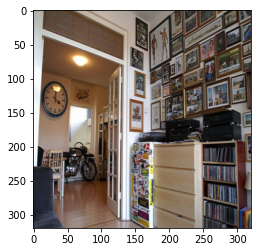

Labels = [chair, motorbike, sofa, ]
Top5 = [bird, dog, person, car, chair, ]
Top1 = chair


In [15]:
img, lbls = next(l_iter)  
img_rgb = ((np.moveaxis(img.numpy().squeeze(),0,2))*mean_std[1]+mean_std[0])
plt.imshow(np.clip(img_rgb,0,1))
plt.show()
lbls_str = lbls2names(lbls)
print("Labels = " + lbls_str)

with torch.no_grad():
    inputs = img.to(device)
    res = torch.sigmoid(network(inputs))
    # Remember the sigmoid function at the end of the network

#Show top5 and top1 predicted labels
prediction = np.squeeze(res.cpu().numpy())
top1 = np.argsort(prediction)[-1]
top5 = np.argsort(prediction)[-5:]
top5_string = "["
for i in top5:
    top5_string = top5_string + class_to_label[i+1] + ", "
top5_string+="]"
print("Top5 = " + top5_string)
print("Top1 = " + class_to_label[top1+1])

### Top-N Accuracy

We now want to quantify our accuracy.  
Implement a Top-5 error measure, i.e. we score whenever a label we expect from the ground-truth appears in our Top-5 predictions.  
Implement also a Top-1 error score.

In [ ]:
top_5_scores = []
top_1_scores = []
for img_nr, data in enumerate(val_loader):
    imgs, lbls = data
    
    network.eval()
    with torch.no_grad():
        inputs = imgs.to(device)
        output = torch.sigmoid(network(inputs))
    prediction = np.squeeze(output.cpu().numpy())
    top5 = np.argsort(prediction, axis=1)[:,-5:]
    top1 = np.argsort(prediction, axis=1)[:,-1]
    
    labels = lbls.numpy()
    
    # implementation top5 error
    count=0
    length=0
    for j in range(32):
        output=np.where(labels[j]==1)
        for index in output:
            if index in top5[j]:
                count+=1
        length+=len(labels[j])
    accuracy=count/length
    print(accuracy)

        


    #rint(label_num)
    #print(label_num)
    #for i in range(32):

    # Implement your on error measure
    # ...

        
# Print your error measures
# ...


**Statement:** The Top-5 error is a fair measure for this evaluation.

**Q4:** Think, discuss, reason.

**Q5:** Suggest and implement your own idea to compute a human interpretable score for the network performance.

#### ... write your answers/ideas in this box

We hope you enjoyed the session! - Feel free to give your feedback and help us improve this lab...

#### ... your ideas for a improvements, peace and a better world in general, here pls :D